##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [137]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [138]:
orig_df = pd.read_csv('datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [139]:
df = pd.read_csv('datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [140]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [141]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [142]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [143]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


'X' and 'Y': Latitude and longitude (location) coordinates of the crime.

'Area_Command': The police designation of the bureau of operation (also encoded as a numerical value).

'NIBRSOffenseCode': Classification code for the crime committed (encoded as a numerical value).

'DayOfWeek': Day of the week when the crime was reported (encoded as a numerical value).

'Time': Hour of the day when the crime was reported.

'VictimCount': The number of persons involved in the incident (this is your target variable).


Input Variables: 'X', 'Y', 'Time', 'DayOfWeek', 'Area_Command', 'NIBRSOffenseCode'.

Target Variable: 'VictimCount'.

In [144]:

description = df.describe()

# Display the summary statistics
print(description)

# Get the range of values for numerical columns
numerical_columns = df.select_dtypes(include=[np.number])  
column_ranges = numerical_columns.agg(['min', 'max'])

# Display the range of values
print(column_ranges)


                X           Y  Area_Command  NIBRSOffenseCode   DayOfWeek  \
count  275.000000  275.000000    275.000000        275.000000  275.000000   
mean  -115.159326   36.143360      3.978182          0.909091    2.981818   
std      0.101294    0.118418      3.045799          0.334878    1.924590   
min   -116.000000   35.068419      0.000000          0.000000    0.000000   
25%   -115.209198   36.114704      1.000000          1.000000    1.000000   
50%   -115.149945   36.152415      3.000000          1.000000    3.000000   
75%   -115.105200   36.183854      6.000000          1.000000    5.000000   
max   -114.625570   37.000000     11.000000          2.000000    6.000000   

             Time  VictimCount  
count  275.000000   275.000000  
mean    11.236364     0.712727  
std      7.039937     0.978427  
min      0.000000     0.000000  
25%      5.000000     0.000000  
50%     11.000000     0.000000  
75%     18.000000     1.000000  
max     23.000000     6.000000  
         

Whether you need to scale, shift, or normalize your data depends on your specific modeling approach and the requirements of the machine learning algorithm you plan to use. Many machine learning algorithms work well with standardized data (mean-centered and scaled to have unit variance), so you may choose to apply scaling or normalization if needed

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [145]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Assuming you have the DataFrame 'df' from Task 1
X = torch.tensor(df.drop(columns=['VictimCount']).values, dtype=torch.float32)
y = torch.tensor(df['VictimCount'].values, dtype=torch.float32)

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader objects for training and testing
batch_size = 64 

# Assuming you want an 80-20 train-test split
split = int(0.8 * len(X))
train_dataset = CustomDataset(X[:split], y[:split])
test_dataset = CustomDataset(X[split:], y[split:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of data by iterating over one dataset 
for batch in train_loader:
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break  

Input shape: torch.Size([64, 6])
Target shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

1.For a regression problem where the goal is to predict a real number (in this case, the number of crime victims), the appropriate loss function is the Mean Squared Error (MSE) loss function. The MSE loss measures the average squared difference between the predicted values and the actual target values.

The MSE loss is defined as:

MSE = (1/N) * Σ(yᵢ - ŷᵢ)²


2.In a regression problem, the size of the predicted output should match the dimensionality of your target variable. 
Since you're predicting the number of crime victims as a real number in this context, 
 the size of the predicted output should be a single real number for each input sample in your dataset.


In [146]:

loss_function = nn.MSELoss()

3.Proposed Architecture:
    Input Layer: Number of neurons should match the number of features in the dataset.
    Multiple Hidden Layers: A common approach might involve 2-3 hidden layers with varying numbers of neurons.
    Activation Function: ReLU (Rectified Linear Unit) is commonly used in hidden layers.
    Output Layer: A single neuron to produce the regression output (prediction for the number of crime victims). 
    
No activation function is applied here.
The choice of the number of layers depends on the complexity of the problem. 
For a starting point, two or three hidden layers might be sufficient, and you can adjust the number of neurons in these layers based on the complexity of the data.


4.Using Adam optimizer, a popular and versatile choice due to its adaptive learning rate and momentum capabilities, 
for training the model. The learning rate determines the step size the optimizer takes during the weight updates. 
A suitable learning rate is typically within the range of 0.001 to 0.01, 
although this can vary based on the dataset and the neural network architecture.




In [147]:
optimizer = optim.Adam(model.parameters(), lr=0.001)  

In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the neural network architecture
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Hyperparameters
input_size = X.shape[1]  
hidden_size = 64  
output_size = 1 
seed = 42

# Create the model, loss function, and optimizer
model = RegressionModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# Training loop
num_epochs = 10  
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Avg. Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for test_batch_X, test_batch_y in test_loader:
            y_pred = model(test_batch_X)
            test_loss += criterion(y_pred, test_batch_y.view(-1, 1)).item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Epoch {epoch + 1} - Test MSE: {avg_test_loss:.4f}")



Epoch 1/10, Avg. Loss: 1.5820
Epoch 1 - Test MSE: 2.1924
Epoch 2/10, Avg. Loss: 1.2066
Epoch 2 - Test MSE: 1.6440
Epoch 3/10, Avg. Loss: 1.1330
Epoch 3 - Test MSE: 1.6331
Epoch 4/10, Avg. Loss: 0.9343
Epoch 4 - Test MSE: 1.4770
Epoch 5/10, Avg. Loss: 0.9933
Epoch 5 - Test MSE: 1.5116
Epoch 6/10, Avg. Loss: 0.9489
Epoch 6 - Test MSE: 1.6147
Epoch 7/10, Avg. Loss: 0.8497
Epoch 7 - Test MSE: 1.4902
Epoch 8/10, Avg. Loss: 0.8017
Epoch 8 - Test MSE: 1.6846
Epoch 9/10, Avg. Loss: 0.8920
Epoch 9 - Test MSE: 1.4898
Epoch 10/10, Avg. Loss: 0.8019
Epoch 10 - Test MSE: 1.6608


Evaluate the model's performance using the test data. If the model is not training well, you can adjust hyperparameters such as the learning rate, hidden layer size, activation functions, and the number of layers to achieve better accuracy.

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the neural network architecture
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Hyperparameters
input_size = X.shape[1]  
hidden_size = 64 
output_size = 1 

# Create the model, loss function, and optimizer
model = RegressionModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  
seed = 42
# Training loop
num_epochs = 10 
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Avg. Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for test_batch_X, test_batch_y in test_loader:
            y_pred = model(test_batch_X)
            test_loss += criterion(y_pred, test_batch_y.view(-1, 1)).item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Epoch {epoch + 1} - Test MSE: {avg_test_loss:.4f}")



Epoch 1/10, Avg. Loss: 3.9430
Epoch 1 - Test MSE: 3.6099
Epoch 2/10, Avg. Loss: 1.8504
Epoch 2 - Test MSE: 2.0807
Epoch 3/10, Avg. Loss: 1.0243
Epoch 3 - Test MSE: 1.5369
Epoch 4/10, Avg. Loss: 0.8308
Epoch 4 - Test MSE: 1.5456
Epoch 5/10, Avg. Loss: 1.0022
Epoch 5 - Test MSE: 1.6297
Epoch 6/10, Avg. Loss: 1.0477
Epoch 6 - Test MSE: 1.5988
Epoch 7/10, Avg. Loss: 0.9721
Epoch 7 - Test MSE: 1.5236
Epoch 8/10, Avg. Loss: 0.8212
Epoch 8 - Test MSE: 1.5032
Epoch 9/10, Avg. Loss: 0.8712
Epoch 9 - Test MSE: 1.5504
Epoch 10/10, Avg. Loss: 0.9558
Epoch 10 - Test MSE: 1.5948


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [150]:
import numpy as np

# Assuming y contains your output data
unique_classes = np.unique(y)
num_classes = len(unique_classes)

print("Number of Classes:", num_classes)


Number of Classes: 7


Differences
Output Layer: For regression tasks, the output layer typically consists of a single neuron with linear or no activation. In contrast, for classification tasks, the number of output neurons matches the number of classes with specific activation functions.
Loss Function: Different loss functions are used based on the task type - MSE, MAE for regression, and Cross-Entropy based losses for classification.

In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Load your dataset or create sample data
X = df.drop(columns='VictimCount').values 
y = df['VictimCount'].values 

# Convert the data to appropriate data types
X = torch.tensor(X, dtype=torch.float32)  
y = torch.tensor(y, dtype=torch.int64)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test) 

# Convert class labels to LongTensor
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define your neural network model and hyperparameters
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x


unique_classes = np.unique(y)
num_classes = len(unique_classes)
input_size = X_train.shape[1]
hidden_size = 32  
output_size = num_classes

model = ClassificationModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader objects for training and testing
batch_size = 64 
train_dataset = TensorDataset(torch.Tensor(X_train), y_train)
test_dataset = TensorDataset(torch.Tensor(X_test), y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Early stopping
best_accuracy = 0
early_stopping_patience = 10
no_improvement = 0

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        total_correct = 0

        for test_batch_X, test_batch_y in test_loader:
            y_pred = model(test_batch_X)
            total_correct += (torch.argmax(y_pred, dim=1) == test_batch_y).sum().item()

        test_accuracy = total_correct / len(test_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy*100:.4f}")

        # Learning rate scheduler step based on test accuracy
        scheduler.step(avg_loss)

        # Early stopping
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stopping. Best test accuracy:", best_accuracy*100)
                break

Epoch 1/50, Avg. Loss: 1.6236, Test Accuracy: 38.1818
Epoch 2/50, Avg. Loss: 1.1750, Test Accuracy: 58.1818
Epoch 3/50, Avg. Loss: 1.1992, Test Accuracy: 38.1818
Epoch 4/50, Avg. Loss: 1.1482, Test Accuracy: 36.3636
Epoch 5/50, Avg. Loss: 1.2252, Test Accuracy: 56.3636
Epoch 6/50, Avg. Loss: 1.1005, Test Accuracy: 43.6364
Epoch 7/50, Avg. Loss: 1.1033, Test Accuracy: 47.2727
Epoch 8/50, Avg. Loss: 1.1062, Test Accuracy: 43.6364
Epoch 9/50, Avg. Loss: 1.0371, Test Accuracy: 34.5455
Epoch 10/50, Avg. Loss: 1.0364, Test Accuracy: 41.8182
Epoch 11/50, Avg. Loss: 1.0825, Test Accuracy: 49.0909
Epoch 12/50, Avg. Loss: 1.0113, Test Accuracy: 50.9091
Early stopping. Best test accuracy: 58.18181818181818


In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Load your dataset or create sample data
X = df.drop(columns='VictimCount').values 
y = df['VictimCount'].values  

# Convert the data to appropriate data types
X = torch.tensor(X, dtype=torch.float32) 
y = torch.tensor(y, dtype=torch.int64)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# Convert class labels to LongTensor
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define your neural network model and hyperparameters
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x


unique_classes = np.unique(y)
num_classes = len(unique_classes)
input_size = X_train.shape[1]
hidden_size = 64  
output_size = num_classes

model = ClassificationModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader objects for training and testing
batch_size = 64 
train_dataset = TensorDataset(torch.Tensor(X_train), y_train)
test_dataset = TensorDataset(torch.Tensor(X_test), y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Early stopping
best_accuracy = 0
early_stopping_patience = 10
no_improvement = 0

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        total_correct = 0

        for test_batch_X, test_batch_y in test_loader:
            y_pred = model(test_batch_X)
            total_correct += (torch.argmax(y_pred, dim=1) == test_batch_y).sum().item()

        test_accuracy = total_correct / len(test_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy*100:.4f}")

        # Learning rate scheduler step based on test accuracy
        scheduler.step(avg_loss)

        # Early stopping
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stopping. Best test accuracy:", best_accuracy*100)
                break

Epoch 1/50, Avg. Loss: 1.5706, Test Accuracy: 36.3636
Epoch 2/50, Avg. Loss: 1.2982, Test Accuracy: 34.5455
Epoch 3/50, Avg. Loss: 1.2488, Test Accuracy: 52.7273
Epoch 4/50, Avg. Loss: 1.2222, Test Accuracy: 49.0909
Epoch 5/50, Avg. Loss: 1.1818, Test Accuracy: 45.4545
Epoch 6/50, Avg. Loss: 1.0677, Test Accuracy: 54.5455
Epoch 7/50, Avg. Loss: 1.0037, Test Accuracy: 43.6364
Epoch 8/50, Avg. Loss: 1.0001, Test Accuracy: 50.9091
Epoch 9/50, Avg. Loss: 0.9936, Test Accuracy: 49.0909
Epoch 10/50, Avg. Loss: 0.9660, Test Accuracy: 52.7273
Epoch 11/50, Avg. Loss: 0.9478, Test Accuracy: 54.5455
Epoch 12/50, Avg. Loss: 0.9097, Test Accuracy: 43.6364
Epoch 13/50, Avg. Loss: 0.9297, Test Accuracy: 49.0909
Epoch 14/50, Avg. Loss: 0.9434, Test Accuracy: 56.3636
Epoch 15/50, Avg. Loss: 0.8915, Test Accuracy: 45.4545
Epoch 16/50, Avg. Loss: 0.9135, Test Accuracy: 52.7273
Epoch 17/50, Avg. Loss: 0.9205, Test Accuracy: 50.9091
Epoch 18/50, Avg. Loss: 0.8476, Test Accuracy: 49.0909
Epoch 19/50, Avg. L

Initially, we got 58.18181818181818 accuracy with hidden_size = 32 then updated hidden_size = 64 and learning_rate = 0.1 then achieved best accuracy  at 63.6363 


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

When comparing the results of regression and classification models, determining which one performed better can be challenging. The suitability of each model depends on the unique characteristics of the problem you're addressing. Regression models are well-suited for predicting continuous values, particularly when there is significant variability in the data. In contrast, classification is more appropriate when you're dealing with distinct categories, even if those categories aren't immediately intuitive.

The choice between regression and classification hinges on the nature of the problem, the available data, and the desired outcomes. Ultimately, the "better" approach is the one that best aligns with the specific goals and requirements of your task.

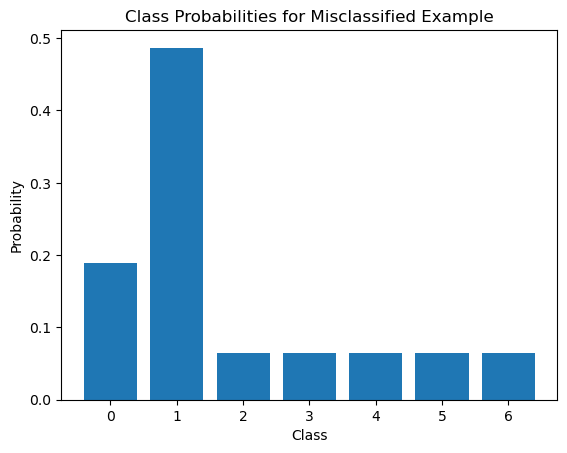

In [153]:
import matplotlib.pyplot as plt
import torch

model.eval()

misclassified_example = None
correct_label = None
with torch.no_grad():
    for test_batch_X, test_batch_y in test_loader:
        y_pred = model(test_batch_X)
        predicted_labels = torch.argmax(y_pred, dim=1)
        misclassified_mask = (predicted_labels != test_batch_y)
        if torch.sum(misclassified_mask) > 0:
            misclassified_example = test_batch_X[misclassified_mask][0]
            correct_label = test_batch_y[misclassified_mask][0]
            break

with torch.no_grad():
    class_probabilities = torch.softmax(model(misclassified_example.unsqueeze(0)), dim=1).squeeze().detach().numpy()


class_labels = range(class_probabilities.shape[0])

plt.bar([str(label) for label in class_labels], class_probabilities)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities for Misclassified Example')
plt.show()



## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


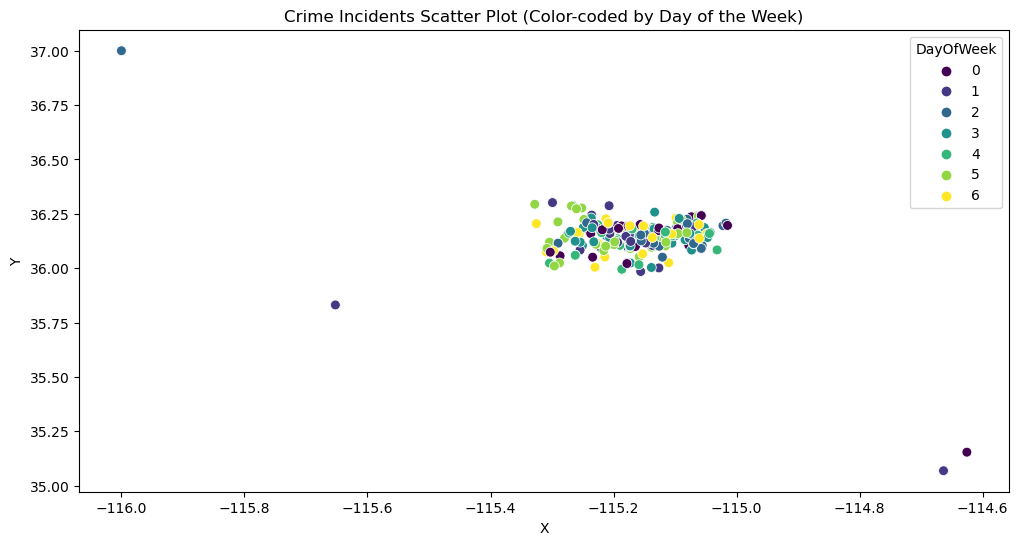

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Y', data=df, hue='DayOfWeek', palette='viridis', s=50)
plt.title('Crime Incidents Scatter Plot (Color-coded by Day of the Week)')
plt.show()


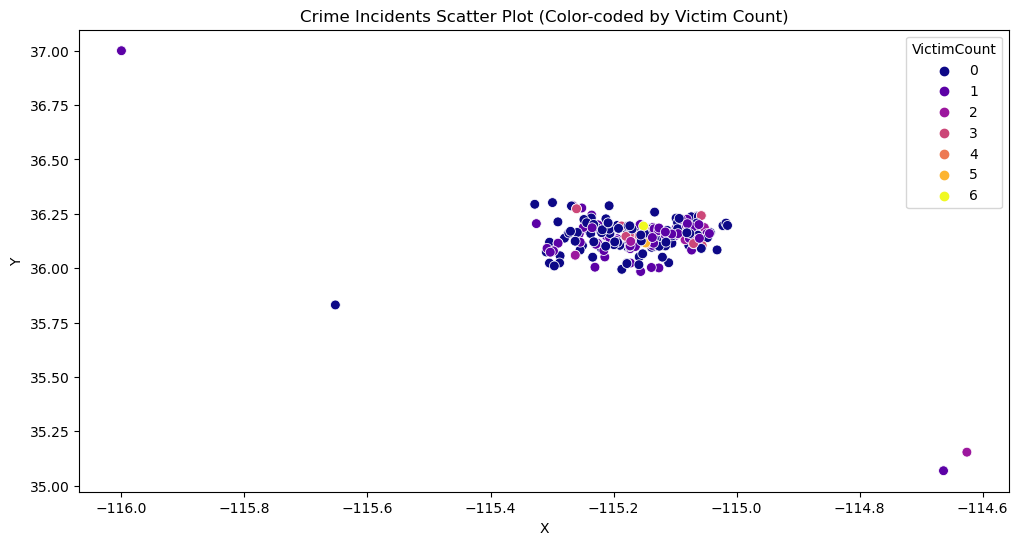

In [155]:

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Y', data=df, hue='VictimCount', palette='plasma', s=50)
plt.title('Crime Incidents Scatter Plot (Color-coded by Victim Count)')
plt.show()


In [156]:
import numpy as np

days_of_week = np.arange(7)

crime_count_by_day = np.bincount(df['DayOfWeek'])

dtype = [('DayOfWeek', int), ('CrimeCount', int)]
crime_count_array = np.array(list(zip(days_of_week, crime_count_by_day)), dtype=dtype)

sorted_crime_count_array = np.sort(crime_count_array, order='CrimeCount')[::-1]

print("Most Frequent Days for Crimes:")
for day, count in sorted_crime_count_array:
    print(f"Day {day}: {count} crimes")


Most Frequent Days for Crimes:
Day 4: 51 crimes
Day 3: 44 crimes
Day 5: 43 crimes
Day 0: 40 crimes
Day 1: 37 crimes
Day 2: 32 crimes
Day 6: 28 crimes
